# Convert BERT regressor into multiclassifier

code obtained from

https://towardsdatascience.com/multi-class-text-classification-with-deep-learning-using-bert-b59ca2f5c613

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

storyPoints = pd.read_csv("CompleteStoryPoints.csv")
data = pd.read_csv("dataset.csv", sep=',')
df = data[['Summary', 'HoursActualRound']]
storyPoints.head()

,issuekey,title,description,title+description,storypoint,project
0,TESB-1,Investigation: S1 Improved user experience wit...,NaN,Investigation: S1 Improved user experience wit...,5.0,talentdesb
1,TESB-2,Investigate: S2 Business Service Implementatio...,NaN,Investigate: S2 Business Service Implementatio...,5.0,talentdesb
2,TESB-3,Investigate: S3 Improved XML Data Handling Com...,NaN,Investigate: S3 Improved XML Data Handling Com...,5.0,talentdesb
3,TESB-4,Investigate: S7 TIS RTx based on the Service F...,NaN,Investigate: S7 TIS RTx based on the Service F...,5.0,talentdesb
4,TESB-5,Investigate: github migration new opportunitie...,NaN,Investigate: github migration new opportunitie...,5.0,talentdesb


## Let's first analyze the concatenation of all projects containing storypoints 

In [ ]:
sp_df = storyPoints[['title+description', 'storypoint']]
sp_df = storyPoints[['title+description', 'storypoint']]
sp_df['storypoint'].value_counts().count()

3630

So it seems like there are 3630 different unique values representing the amount of story points

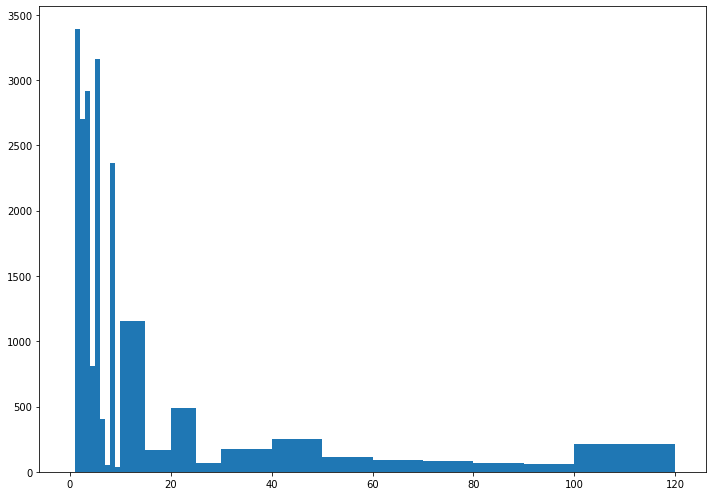

In [ ]:
# Let's now check the distribution of story points
from matplotlib import pyplot as plt

# Creating histogram
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7),
                        tight_layout = True)
 
axs.hist(sp_df['storypoint'], bins = [0,1,2,3,4,5,6,7,8,9,10,15,20,25,30,40,50,60,70,80,90,100,120])
 
# Show plot
plt.show()

So now it seems like the most part of the userstories have less than 20 story points

In [ ]:
dups = sp_df.groupby(sp_df.storypoint.tolist()).size().reset_index().rename(columns={0:'count'})
dups

,index,count
0,1.0,3395
1,2.0,2703
2,3.0,2917
3,4.0,811
4,5.0,3163
...,...,...
3625,2248.0,1
3626,2249.0,1
3627,2250.0,1
3628,2251.0,1


It seems that we have a lot of decimal values, so let's convert them into integers

In [ ]:
target=sp_df['storypoint'].astype(int)
target.value_counts().count()

2252

Ok we have reduced 1000 classes, let's take a closer look

In [ ]:
dups = target.groupby(target.tolist()).size().reset_index().rename(columns={0:'count'})
dups

,index,storypoint
0,1,3395
1,2,2703
2,3,2917
3,4,811
4,5,3163
...,...,...
2247,2248,1
2248,2249,1
2249,2250,1
2250,2251,1


Ok now that our target has decreased the number of classes, lets group them

In [ ]:
possible_labels = target.unique()
pos_lab_sort = possible_labels.sort()
print(possible_labels)

[   1    2    3 ... 2250 2251 2252]


In [ ]:
# This function will cluster the story points into groups

def clusterSP(df):
  arr=[]
  for i in range(len(df)):
    if df[i] >0 and df[i]<=1:
      group = 1
    elif df[i] >1 and df[i]<=2:
      group = 2
    elif df[i] >2 and df[i]<=3:
      group = 3
    elif df[i] >3 and df[i]<=5:
      group = 5
    elif df[i] >5 and df[i]<=8:
      group = 8
    elif df[i] >8 and df[i]<=200:
      group = 200
    elif df[i] >200 and df[i]<=500:
      group = 500
    elif df[i] >500 and df[i]<=1000:
      group = 1000
    elif df[i] >1000 and df[i]<=3000:
      group = 3000

    arr.append(group)

  return(arr)

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index

In [ ]:
clustersTarget = pd.DataFrame(clusterSP(target))
clustersTarget.columns = ['groupedLabels']

In [ ]:
storyPointsCluster = pd.concat([target,clustersTarget], axis=1)
storyPointsCluster

,storypoint,groupedLabels
0,5,5
1,5,5
2,5,5
3,5,5
4,5,5
...,...,...
23308,5,5
23309,3,3
23310,3,3
23311,3,3


In [ ]:
storyPointsCluster['groupedLabels'].unique()

array([   5,    3,    8,    2,    1,  200,  500, 1000, 3000])

In [ ]:
dups = storyPointsCluster.groupby(storyPointsCluster.groupedLabels.tolist()).size().reset_index().rename(columns={0:'count'})
dups

,index,count
0,1,3395
1,2,2703
2,3,2917
3,5,3974
4,8,2823
5,200,3359
6,500,1340
7,1000,1166
8,3000,1636


In [ ]:
possible_labels = storyPointsCluster.groupedLabels.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{5: 0, 3: 1, 8: 2, 2: 3, 1: 4, 200: 5, 500: 6, 1000: 7, 3000: 8}

In [ ]:
df = storyPointsCluster.groupedLabels.replace(label_dict)
df

0        0
1        0
2        0
3        0
4        0
        ..
23308    0
23309    1
23310    1
23311    1
23312    2
Name: groupedLabels, Length: 23313, dtype: int64

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from tqdm.notebook import tqdm

from transformers import BertTokenizer
from torch.utils.data import TensorDataset

from transformers import BertForSequenceClassification

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(sp_df['title+description'],
                                                  df,
                                                  test_size=0.15, 
                                                  random_state=42)

In [ ]:
X_train

In [ ]:
y_train

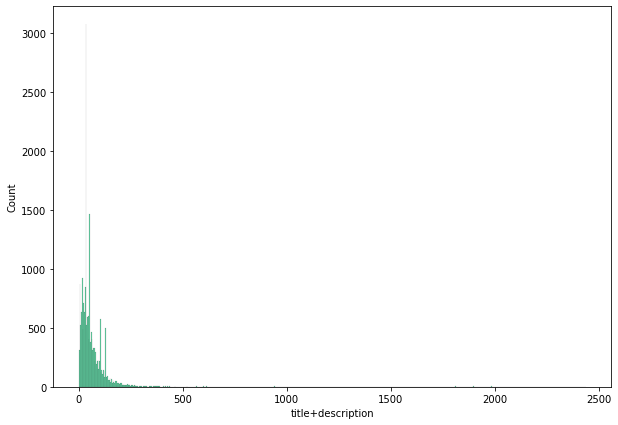

In [ ]:
word_count = X_train.apply(lambda x: len(x.split()))
fig = plt.figure(figsize=[10,7])
sns.histplot(word_count, color=sns.xkcd_rgb['greenish teal'])
plt.show()

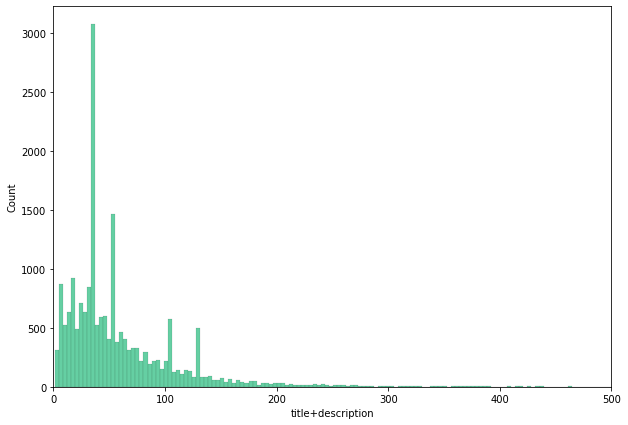

In [ ]:
word_count = X_train.apply(lambda x: len(x.split()))
fig = plt.figure(figsize=[10,7])
sns.histplot(word_count, color=sns.xkcd_rgb['greenish teal'])
plt.xlim(0, 500)
plt.show()

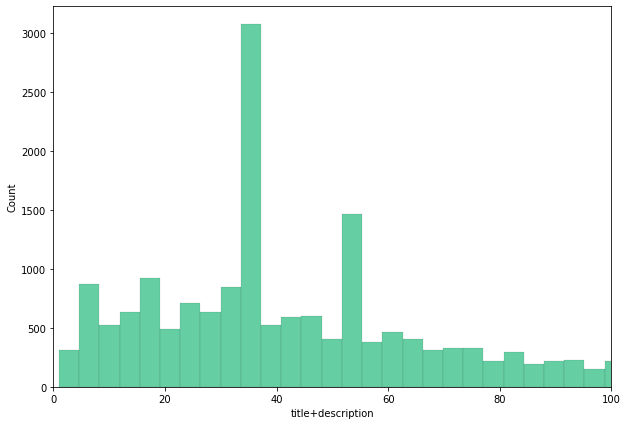

In [ ]:
word_count = X_train.apply(lambda x: len(x.split()))
fig = plt.figure(figsize=[10,7])
sns.histplot(word_count, color=sns.xkcd_rgb['greenish teal'])
plt.xlim(0, 100)
plt.show()

In [ ]:
wc_test = X_train.apply(lambda x: len(x.split()))
wc_test

16188     21
20182     93
13420    103
19803      7
6580      13
        ... 
11964     75
21575     88
5390      37
860        5
15795     20
Name: title+description, Length: 19816, dtype: int64

In [ ]:
word_count.max()

2438

In [ ]:
word_count

16188     21
20182     93
13420    103
19803      7
6580      13
        ... 
11964     75
21575     88
5390      37
860        5
15795     20
Name: title+description, Length: 19816, dtype: int64

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', 
                                          do_lower_case=True)

In [ ]:
encoded_data_train = tokenizer.batch_encode_plus(
    X_train.values, 
    add_special_tokens=True, 
    truncation=True,
    return_attention_mask=True, 
    padding='longest', 
    max_length=31, 
    return_tensors='pt'
)

In [ ]:
encoded_data_val = tokenizer.batch_encode_plus(
    X_val.values, 
    add_special_tokens=True, 
    truncation=True,
    return_attention_mask=True, 
    padding='longest', 
    max_length=31, 
    return_tensors='pt'
)

In [ ]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.values)

In [ ]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val.values)

dataset_train = TensorDataset(input_ids_train, attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

## Hours dataset for validation

### Let's download the pretrained BERT Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=9,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 1

dataloader_train = DataLoader(dataset_train, 
                              sampler=RandomSampler(dataset_train), 
                              batch_size=batch_size)

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(model.parameters(),
                  lr=1e-5, 
                  eps=1e-8)
                  
epochs = 20

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,
                                            num_training_steps=len(dataloader_train)*epochs)


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()

    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [ ]:
import numpy as np
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals
 

In [ ]:
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(dataloader_train, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
    if epoch%10 == 0:
      torch.save(model.state_dict(), f'/content/drive/MyDrive/finetuned_StoryPoint_BERT_epoch_{epoch}_BS1_LR-5_LW31.model')
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_validation)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (Weighted): {val_f1}')

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 1
Training loss: 1.7234379754638123
Validation loss: 1.777086373606392
F1 Score (Weighted): 0.33362712697890723


Epoch 2:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 2
Training loss: 1.6875321567461399
Validation loss: 1.768341441412229
F1 Score (Weighted): 0.3806491004362967


Epoch 3:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 3
Training loss: 1.6380089175931103
Validation loss: 2.338864389526567
F1 Score (Weighted): 0.3921101727710201


Epoch 4:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 4
Training loss: 1.5608054361023218
Validation loss: 2.8990669708561767
F1 Score (Weighted): 0.389658020694574


Epoch 5:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 5
Training loss: 1.4176931235377568
Validation loss: 3.305854284724225
F1 Score (Weighted): 0.38039814157046686


Epoch 6:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 6
Training loss: 1.1665761474429206
Validation loss: 3.8936652569385597
F1 Score (Weighted): 0.3907147728335191


Epoch 7:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 7
Training loss: 0.9965967017408336
Validation loss: 4.291350067294829
F1 Score (Weighted): 0.38507011177722655


Epoch 8:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 8
Training loss: 0.8434204197767495
Validation loss: 4.477927968870786
F1 Score (Weighted): 0.38303852765634483


Epoch 9:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 9
Training loss: 0.7484483236222417
Validation loss: 4.66815717448562
F1 Score (Weighted): 0.38638509788709074


Epoch 10:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 10
Training loss: 0.6539397775943004
Validation loss: 4.980357907303185
F1 Score (Weighted): 0.3830418456664856


Epoch 11:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 11
Training loss: 0.5957491771553888
Validation loss: 5.172335593291817
F1 Score (Weighted): 0.38492512846895227


Epoch 12:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 12
Training loss: 0.5668287103507956
Validation loss: 5.001038520076835
F1 Score (Weighted): 0.39769762930107766


Epoch 13:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 13
Training loss: 0.5236826415515426
Validation loss: 5.4832650647068215
F1 Score (Weighted): 0.38144881588717383


Epoch 14:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 14
Training loss: 0.49655673066531164
Validation loss: 5.487090615288797
F1 Score (Weighted): 0.3861640128784625


Epoch 15:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 15
Training loss: 0.473328083461249
Validation loss: 5.697063909433267
F1 Score (Weighted): 0.3861357753224335


Epoch 16:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 16
Training loss: 0.44513556681187705
Validation loss: 5.834257070290553
F1 Score (Weighted): 0.39298256870860326


Epoch 17:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 17
Training loss: 0.4423915113160585
Validation loss: 5.965040038488027
F1 Score (Weighted): 0.3944797995837887


Epoch 18:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 18
Training loss: 0.4265678320694434
Validation loss: 6.057089595818846
F1 Score (Weighted): 0.3839042858281483


Epoch 19:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 19
Training loss: 0.42078949915920133
Validation loss: 6.167329026912725
F1 Score (Weighted): 0.38840105122849833


Epoch 20:   0%|          | 0/19816 [00:00<?, ?it/s]


Epoch 20
Training loss: 0.41759639825162975
Validation loss: 6.165014639349295
F1 Score (Weighted): 0.39151673018036376


# Now that our model has been fine tuned with the first dataset regarding story points, lets use it to predict the time in hours the user stories will take

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",
                                                      num_labels=9,
                                                      output_attentions=False,
                                                      output_hidden_states=False)

model.to(device)

model.load_state_dict(torch.load('/content/drive/MyDrive/finetuned_StoryPoint_BERT_epoch_20_BS1_LR-5_LW31.model', map_location=torch.device('cpu')))



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

<All keys matched successfully>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv("dataset.csv", sep=',')
df = data[['Summary', 'HoursActualRound']]
df['HoursActualRound'].value_counts().count()

189

Let's now create a dictionary with all our labels and their cons

In [ ]:
possible_labels = df.HoursActualRound.unique()
pos_lab_sort = possible_labels.sort()
print(possible_labels)

[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   93   94   95   96   97   98
   99  100  101  102  104  105  106  107  108  109  111  112  113  115
  118  119  120  122  123  126  127  128  129  130  135  136  138  140
  142  143  147  149  150  152  154  156  157  158  159  162  163  164
  165  166  167  169  171  175  176  177  187  190  193  197  201  204
  208  209  213  214  218  221  222  254  260  269  280  288  301  302
  303  317  328  334  340  343  367  387  408  431  443  456  474  476
  518  558  563  698  833 2005 2490]


In [ ]:
def cluster(df):
  arr=[]
  for i in range(len(df)):
    if df[i] >0 and df[i]<=5:
      group = 5
    elif df[i] >5 and df[i]<=10:
      group = 10
    elif df[i] >10 and df[i]<=15:
      group = 15
    elif df[i] >15 and df[i]<=20:
      group = 20
    elif df[i] >20 and df[i]<=25:
      group = 25
    elif df[i] >25 and df[i]<=30:
      group = 30
    elif df[i] >30 and df[i]<=60:
      group = 60
    elif df[i] >60 and df[i]<=90:
      group = 90
    elif df[i] >90 and df[i]<=3000:
      group = 100

    arr.append(group)

  return(arr)

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
#label_dict

In [ ]:
df2 = pd.DataFrame(cluster(df["HoursActualRound"]))
df2.columns = ['groupedLabels']

In [ ]:
df3 = pd.concat([df["HoursActualRound"],df2], axis=1)
df3

,HoursActualRound,groupedLabels
0,2,5
1,7,10
2,1,5
3,1,5
4,4,5
...,...,...
12294,1,5
12295,19,20
12296,8,10
12297,1,5


In [ ]:
df['label'] = df.HoursActualRound.replace(label_dict)

<ipython-input-17-e7aeb00ec30a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df.HoursActualRound.replace(label_dict)


In [ ]:
df['label'].unique()

array([  2,   7,   1,   4,  14,  18,   0,  70,  12, 103,  28,   5,  21,
         3,  42,  11,  35,   6,   8,   9,  97,  49,  19,  15,  23,  29,
        25,  22,  47,  51,  10,  24,  26,  16,  27,  33,  41,  53,  78,
        56, 126,  13,  40,  31,  32,  63,  38,  20,  61,  43,  36,  64,
        84,  17,  68,  46,  71,  80,  30,  50,  52, 172, 169, 111,  90,
        34,  44, 133,  39,  48,  59, 117, 150, 112, 109,  37,  93,  54,
        45, 100,  74,  86,  82,  75, 122, 142, 168, 177,  95,  72, 135,
       107, 106,  98,  76, 137,  96, 123, 162,  58,  62, 164, 101,  69,
        81, 145,  60, 148, 161, 165,  92,  65, 186,  79,  55,  89, 159,
        88, 108, 140,  73,  85,  99, 184,  77, 124, 173, 160, 125, 128,
       181, 143,  66, 120, 119, 151, 131, 146, 154, 188, 118, 104, 121,
       114, 136, 152,  83, 183, 102, 139, 141, 134, 105, 130, 167, 144,
       127,  94, 187, 180, 149,  87, 185,  67, 115, 155, 110, 175, 158,
       138, 182, 129, 176,  91, 166, 153, 170,  57, 174, 178, 15

In [ ]:
dups2 = df2.groupby(df2.groupedLabels.tolist()).size().reset_index().rename(columns={0:'count'})
dups2

,index,count
0,5,7712
1,10,1795
2,15,909
3,20,389
4,25,284
5,30,215
6,60,521
7,90,191
8,100,283


In [ ]:
possible_labels = df2.groupedLabels.unique()
label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{5: 0, 10: 1, 15: 2, 20: 3, 90: 4, 100: 5, 30: 6, 25: 7, 60: 8}

In [ ]:
df['label'] = df2.groupedLabels.replace(label_dict)
df['label']

<ipython-input-21-2cb07ed1d4a8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = df2.groupedLabels.replace(label_dict)


0        0
1        1
2        0
3        0
4        0
        ..
12294    0
12295    3
12296    1
12297    0
12298    0
Name: label, Length: 12299, dtype: int64

In [ ]:
X_val = df.Summary
y_val = df.label

Now let's see how many words each user story has

### Tokenize 

In [ ]:
X_val

0        Flag RI on SCM Message Summary screen using me...
1              Allow RI Policies to be marked as Exhausted
2                       Fix Invalid UWREF Line DX402L99A1N
3        New rows in the diary event for the SCM are re...
4        Application Screen Size - Need to set Min Size...
                               ...                        
12294                          YYY ZZZ - Month-End Support
12295                     Management Tasks - December 2014
12296         Reconfiguring Home Network For New Broadband
12297                        Cancelling Silverbug Contract
12298                                 SiP Admin - Invoices
Name: Summary, Length: 12299, dtype: object

In [ ]:
encoded_data_val = tokenizer.batch_encode_plus(
    X_val.values, 
    add_special_tokens=True, 
    truncation=True,
    return_attention_mask=True, 
    padding='longest', 
    max_length=60, 
    return_tensors='pt'
)

Here we have the input ids which is our embedded vector of max 31 with padding, the attention mask and the labels

In [ ]:
input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_val.values)

dataset_val = TensorDataset(input_ids_val, attention_masks_val, labels_val)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 1

dataloader_validation = DataLoader(dataset_val, 
                                   sampler=SequentialSampler(dataset_val), 
                                   batch_size=batch_size)

In [ ]:
_, predictions, true_vals = evaluate(dataloader_validation)
accuracy_per_class(predictions, true_vals)

Class: 5
Accuracy: 1236/7712

Class: 10
Accuracy: 262/1795

Class: 15
Accuracy: 92/909

Class: 20
Accuracy: 114/389

Class: 90
Accuracy: 13/191

Class: 100
Accuracy: 29/283

Class: 30
Accuracy: 0/215

Class: 25
Accuracy: 0/284

Class: 60
Accuracy: 0/521

